# Support Vector Machine

### Loading and Visualizing Data 

In [3]:
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
data = sio.loadmat('ex6data1.mat')
X = data['X']
y = data['y']

x_min = X[:,0].min() - 0.1
x_max = X[:,0].max() + 0.1
y_min = X[:,1].min() - 0.1
y_max = X[:,1].max() + 0.1

# plots the data points X and y into a new figure 
def plotDataClassification(X, y):
    for index,val in enumerate(y):
        if y[index] == 0:
            plt.scatter(X[index, 0], X[index, 1], color='blue', s=7)
        else:
            plt.scatter(X[index, 0], X[index, 1], color='red', s=7)
    
    tolerance = 0.3
    plt.axis([min(X[:, 0]) - tolerance, max(X[:, 0]) + tolerance, min(X[:, 1]) - tolerance, max(X[:, 1]) + tolerance])        
    plt.xlabel('X axes')
    plt.ylabel('y axes')
    
    
plotDataClassification(X, y)


### Train a linear SVM on the dataset and plot the decision boundary learned

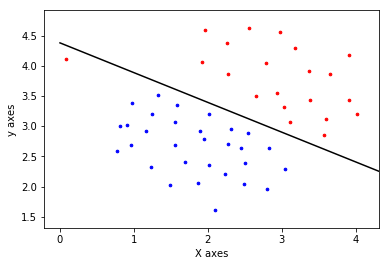

In [4]:
# training
C=10
clf = svm.SVC(kernel='linear', C=C)
clf.fit(X, y.ravel())

# evaluate accuracy
accuracy = clf.score(X, y)

# make new prediction
prediction = clf.predict([[5.9643, 10.5957]])

# plot decision boundary
def plot_linear_boundary(clf):
    # w in this case is a <2,1> vector containing theta1 and theta2, the optimized coefficients related to x1 and x2
    w = clf.coef_[0]

    # line slope
    a = -w[0] / w[1]

    # generating an x grid
    xx = np.linspace(0,12)

    # calculating the decision boundary function on the x grid
    # clf.intercept_[0] is actually equal to theta0
    yy = a * xx - clf.intercept_[0] / w[1]

    # plot the line
    h0 = plt.plot(xx, yy, 'k-', label="non weighted div")
plot_linear_boundary(clf)
plotDataClassification(X, y)


### Gaussian Kernel

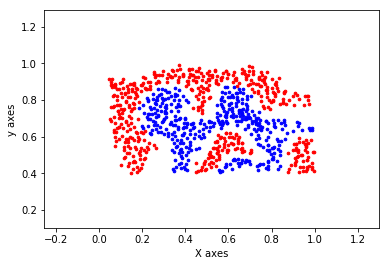

In [5]:
data = sio.loadmat('ex6data2.mat')
X = data['X']
y = data['y']

# plot data
plotDataClassification(X, y)


In [33]:
# todo: plot decision boundary for non-linear function

### Spam Classification with SVMs

In [135]:
import email
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re, cgi
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize


# reads the fixed vocabulary list in vocab.txt and returns a cell array of the words in vocabList
def get_vocabList():
    vocab = pd.read_table('vocab.txt', delim_whitespace=True, header=None)
    vocab = vocab.iloc[:,-1].values.tolist()
    return vocab
       

# preprocesses the body of an email and returns a list of indices of the words contained in the email
def process_email(file_contents):
   # read email
    with open(file_contents, 'r', encoding='ISO-8859-1') as myfile:
        processed_email = myfile.read()
        original_email = processed_email
        
    # extract body's mail
    b = email.message_from_string(processed_email)    
    if b.is_multipart():
        for payload in b.get_payload():
            # if payload.is_multipart(): ...
            processed_email = payload.get_payload()
        else:
            processed_email = b.get_payload()
            
    vocabList = get_vocabList()
    
    
    # set all character in lower case
    processed_email = str(processed_email).lower()

    # strip all HTML
    processed_email = re.sub('<[^<]+?>', '', processed_email)

    # replace any number into the string 'number'
    processed_email = re.sub('[0-9]+', 'number ', processed_email) 

    # replace strings starting with http:// or https:// with the string 'httpaddr'
    processed_email = re.sub('(http|https)://[^\s]*', 'httpaddr ', processed_email) 

    # replace email with string 'emailaddr'
    processed_email = re.sub('[^\s]+@[^\s]+', 'emailaddr ', processed_email) 

    # replace dollar sign ($) with string 'dollar'
    processed_email = re.sub('[$]+', 'dollar ', processed_email) 
    
    # delete non-alphanumeric characters
    processed_email = re.sub('[^a-zA-Z0-9]', ' ', processed_email)
    
    word_indices = np.array([])
    for word in processed_email.split():
        ps = PorterStemmer()
        # stem the word
        word = ps.stem(word)
        
        # if the word is in vocabList, insert in word_indices array the vocabList's index of that word 
        for index in range(len(vocabList)):
            if vocabList[index] == word:
                word_indices = np.append(word_indices, index)
    return word_indices, original_email, vocabList, processed_email

# takes in a word_indices vector and produces a feature vector from the word indices
def email_feature(word_indices, vocabList):
    x = np.zeros(len(vocabList))
    for index in range(len(word_indices)):
        x[int(word_indices[index])] = 1
    return x

#### Load dataset and train

In [168]:
num_email_spam = 500
num_email_non_spam = 500
num_email_train = 1000
num_of_feature = 1899



X_spam = np.zeros(shape=(num_email_spam, num_of_feature))
X_non_spam = np.zeros(shape=(num_email_non_spam, num_of_feature))
y = np.zeros(shape=(num_email_train, 1))


current_mail = 0

spam_email_dir = '/home/pptr/Desktop/machine-learning-ng/assignment6/ex6/spamAssassinPublicCorpus/spamEmails/'

# load and process spam mails (500 mails)
for entry in os.scandir(spam_email_dir):
    if entry.is_file():
       # process single mail
        mail_location = spam_email_dir + entry.name
        word_indices, original_email, vocabList, processed_email = process_email(mail_location)
        feature = email_feature(word_indices, vocabList)
        X_spam[current_mail, :] = feature
        y[current_mail] = 1 # 1 because it is a spam email
        current_mail += 1

non_spam_email_dir = '/home/pptr/Desktop/machine-learning-ng/assignment6/ex6/spamAssassinPublicCorpus/nonSpamEmails/'
current_mail = 0


# load and process non-spam mails (500 mails)
for entry in os.scandir(non_spam_email_dir):
    if entry.is_file():
       # process single mail
        mail_location = non_spam_email_dir + entry.name
        word_indices, original_email, vocabList, processed_email = process_email(mail_location)
        feature = email_feature(word_indices, vocabList)
        X_non_spam[current_mail, :] = feature
        current_mail += 1
        
#concatenate

X = np.concatenate((X_spam, X_non_spam))
#print(X.shape)
#print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#print(X_train.shape, y_train.shape)
#print(X_test.shape, y_test.shape)

# training
C=0.1
clf = svm.SVC(kernel='linear', C=C)
clf.fit(X_train, y_train.ravel())

train_accuracy = (clf.predict(X_train).reshape(-1,1) == y_train.reshape(-1,1)).sum()/y_train.shape[0]
test_accuracy = (clf.predict(X_test).reshape(-1,1) == y_test.reshape(-1,1)).sum()/y_test.shape[0]
print('Linear SVM Decision Boundary with C = 0.1. Train Accuracy = %2.1f%%; Test Accuracy = %2.1f%%' % (train_accuracy*100, test_accuracy*100))


Linear SVM Decision Boundary with C = 0.1. Train Accuracy = 90.6%; Test Accuracy = 88.7%


### Test on unseen mail


#### Non spam email

In [179]:
word_indices, original_email, vocabList, processed_email = process_email('emailSample1.txt')
feature = email_feature(word_indices, vocabList)
print(original_email)
print('Classified as (1 indicates spam, 0 indicates not spam):', clf.predict(feature.reshape(-1, 1).T))

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com


Classified as (1 indicates spam, 0 indicates not spam): [0.]


#### Spam email

In [185]:
word_indices, original_email, vocabList, processed_email = process_email('mySpamEmailExample.txt')
feature = email_feature(word_indices, vocabList)
print(original_email)
print('Classified as (1 indicates spam, 0 indicates not spam):', clf.predict(feature.reshape(-1, 1).T))

From fort@bluemail.dk  Thu Aug 22 18:28:10 2002
Return-Path: <fort@bluemail.dk>
Delivered-To: zzzz@localhost.spamassassin.taint.org
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 9367F43F99
	for <zzzz@localhost>; Thu, 22 Aug 2002 13:28:06 -0400 (EDT)
Received: from mail.webnote.net [193.120.211.219]
	by localhost with POP3 (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 18:28:06 +0100 (IST)
Received: from smtp.easydns.com (smtp.easydns.com [205.210.42.30])
	by webnote.net (8.9.3/8.9.3) with ESMTP id SAA05963;
	Thu, 22 Aug 2002 18:25:04 +0100
From: fort@bluemail.dk
Received: from bluemail.dk (217-127-249-196.uc.nombres.ttd.es [217.127.249.196])
	by smtp.easydns.com (Postfix) with SMTP
	id 3FBEB2EEF1; Thu, 22 Aug 2002 13:24:37 -0400 (EDT)
Reply-To: <fort@bluemail.dk>
Message-ID: <000c84d37aae$7338a0a4$3ab55ec5@bjjwxv>
To: mike23@hotmail.com
Subject: FORTUNE 500 COMPANY HIRING, AT HOME REPS.
MiME-Versio

### Testing on pre-processed dataset

In [162]:
data = sio.loadmat('spamTrain.mat')
X_train = data['X']
y_train = data['y']

data = sio.loadmat('spamTest.mat')
X_test = data['Xtest']
y_test = data['ytest']

C=0.1
clf = svm.SVC(kernel='linear', C=C)
clf.fit(X_train, y_train.ravel())

train_accuracy = (clf.predict(X_train).reshape(-1,1) == y_train.reshape(-1,1)).sum()/y_train.shape[0]

test_accuracy = (clf.predict(X_test).reshape(-1,1) == y_test.reshape(-1,1)).sum()/y_test.shape[0]
print('Linear SVM Decision Boundary with C = 0.1. Train Accuracy = %2.1f%%; Test Accuracy = %2.1f%%' % (train_accuracy*100, test_accuracy*100))


Linear SVM Decision Boundary with C = 0.1. Train Accuracy = 99.8%; Test Accuracy = 98.9%


#### Non spam email

In [152]:
word_indices, original_email, vocabList, processed_email = process_email('emailSample1.txt')
feature = email_feature(word_indices, vocabList)
# print(mail)
print('Classified as (1 indicates spam, 0 indicates not spam):', clf.predict(feature.reshape(-1, 1).T))

Classified as (1 indicates spam, 0 indicates not spam): [0]


#### Spam email

In [156]:
word_indices, original_email, vocabList, mail = process_email('spamSample1.txt')
feature = email_feature(word_indices, vocabList)
# print(mail)
print('Classified as (1 indicates spam, 0 indicates not spam):', clf.predict(feature.reshape(-1, 1).T))

Classified as (1 indicates spam, 0 indicates not spam): [1]
